# Проект: Поиск по изображениям

**Цель** проекта: создать модель  для фотохостинга профессиональных фотографов «Со Смыслом» (“With Sense”), чтобы она сопоставляла текст описания фотографии и саму фотографию и резюмировала, насколько они друг другу подходят.

# Описание данных.

Данные состоят из пяти таблиц и двух папок с фотографиями.
В файле **train_dataset.csv** находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания.

В файле **test_queries.csv** находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение.

В файле **CrowdAnnotations.tsv** — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Содержит информацию:
- об имени файла изображения,
- идентификаторе описания,
- о доле людей, подтвердивших, что описание соответствует изображению,
- о количестве человек, подтвердивших, что описание соответствует изображению,
- о количестве человек, подтвердивших, что описание не соответствует изображению.

В файле **ExpertAnnotations.tsv** содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Хранит информацию:
- об имени файла изображения,
- об идентияикаторе описания,
- оценки трёх экспертов о соответствии изображения и описания.

В папке **train_images** содержатся изображения для тренировки модели.

В папке **test_images** содержатся изображения для тестирования модели.

Загрузим необходимые библиотеки.

In [1]:
import os
import pandas as pd
import math
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import notebook
tqdm.pandas()

from PIL import Image
from pathlib import Path


from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, log_loss, f1_score, mean_squared_error


import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, RepeatVector, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
from google.colab import files

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим файлы с данными.

In [3]:
path_1 = '/content/drive/MyDrive/train_images'
path_2 = '/content/drive/MyDrive/test_images'
path_3 = '/content/drive/MyDrive/train_dataset.csv'
path_4 = '/content/drive/MyDrive/test_queries.csv'
path_5 = '/content/drive/MyDrive/ExpertAnnotations.tsv'
path_6 = '/content/drive/MyDrive/test_images.csv'
path_7 = '/content/drive/MyDrive/CrowdAnnotations.tsv'

In [4]:
train_data = pd.read_csv(path_3)
train_data.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [5]:
test_queries = pd.read_csv(path_4, sep='|')
test_queries.head()

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [6]:
expert_df = pd.read_csv(path_5, sep='\t', names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
expert_df.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

In [7]:
test_images = pd.read_csv(path_6, sep='\t')
test_images.head()

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [8]:
crowd_df = pd.read_csv(path_7, sep='\t', names=['image', 'query_id', 'fraction', 'match', 'dismatch'])
crowd_df.head()

image                     query_id  fraction  match  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2       1.0      3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2       0.0      0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2       0.0      0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2       0.0      0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2       0.0      0   

   dismatch  
0         0  
1         3  
2         3  
3         3  
4         3

Все полученные таблицы соответствуют описанию. Посмотрим файлы, содержащие изображения.

In [9]:
def display_images_from_folder(folder_path, num_images=10):
    # Получаем список файлов из папки
    image_files = os.listdir(folder_path)
    num_images = min(num_images, len(image_files))  # Ограничиваем число выводимых изображений

    # Создаем сетку для отображения изображений
    fig, axes = plt.subplots(1, num_images, figsize=(15, 10))

    # Отображаем изображения
    for i in range(num_images):
        image_file = os.path.join(folder_path, image_files[i])
        image = Image.open(image_file)
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.show()

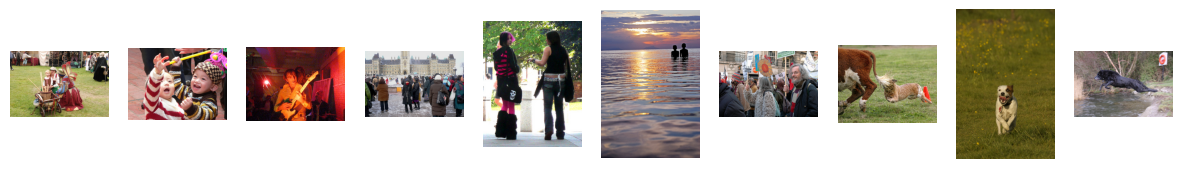

In [10]:
# Выводим изображения из папки train_images
display_images_from_folder(path_1, num_images=10)

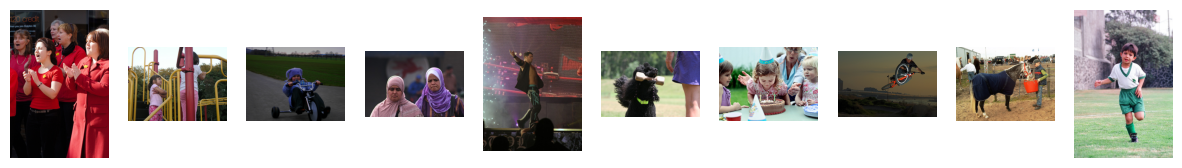

In [11]:
# Выводим изображения из папки test_images
display_images_from_folder(path_2, num_images=10)

Изображения отображаются корректно.

Изучим инфорамцию о таблицах.

In [12]:
expert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [13]:
expert_df['image'].nunique()

1000

In [14]:
expert_df['query_id'].nunique()

977

In [15]:
crowd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   fraction  47830 non-null  float64
 3   match     47830 non-null  int64  
 4   dismatch  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [16]:
crowd_df['image'].nunique()

1000

In [17]:
crowd_df['query_id'].nunique()

1000

In [18]:
test_queries['query_id'].nunique()

500

In [19]:
train_data['query_id'].nunique()

977

In [20]:
expert_df.describe()

expert_1     expert_2     expert_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

**Вывод**
Мы загрузили необходимые библиотеки, загрузили и изучили данные. Все таблицы и изображения отображаются корректно. Модем приступить к исследовательскому анализу.

# Исследовательский анализ данных

Рассмотрим таблицу expert_df. Вычислим среднюю оценку трёх экспертов и создадим новую переменную.

In [21]:
def agr_data(row):

    if row['expert_1'] != row['expert_2'] != row['expert_3']:
        row['expert_avr'] = math.floor((row['expert_1'] + row['expert_2'] + row['expert_3']) / 3)
    else:
        row['expert_avr'] = int(np.median(row['expert_1':'expert_3']))

    return row


expert_df = expert_df.apply(agr_data, axis=1)

expert_df.sample(5)

image                     query_id  expert_1  \
4611  3576259024_9c05b163aa.jpg   302983277_69a4e732e4.jpg#2         1   
3933  3384314832_dffc944152.jpg   300577375_26cc2773a1.jpg#2         1   
2599   293879742_5fe0ffd894.jpg   293879742_5fe0ffd894.jpg#2         4   
3559  3247052319_da8aba1983.jpg  3593392955_a4125087f6.jpg#2         2   
4077   343218198_1ca90e0734.jpg  3545652636_0746537307.jpg#2         1   

      expert_2  expert_3  expert_avr  
4611         1         2           1  
3933         1         1           1  
2599         4         4           4  
3559         2         2           2  
4077         1         2           1

Объединим между собой таблицы, содержащие оценки экспертов и краудсорсинговые оценки по столбцам 'image' и 'query_id'.

In [22]:
data_big = pd.merge(expert_df, crowd_df, on=['image', 'query_id'], how='outer', suffixes=('_expert', '_crowd'))
data_big.sample(5)

image                     query_id  expert_1  \
37416  3480051754_18e5802558.jpg  3058439373_9276a4702a.jpg#2       NaN   
49563   566397227_a469e9e415.jpg   491405109_798222cfd0.jpg#2       NaN   
39654  3544793763_b38546a5e8.jpg   247637795_fdf26a03cf.jpg#2       NaN   
4303    166507476_9be5b9852a.jpg  3227148358_f152303584.jpg#2       NaN   
2313    138718600_f430ebca17.jpg   583174725_6b522b621f.jpg#2       NaN   

       expert_2  expert_3  expert_avr  fraction  match  dismatch  
37416       NaN       NaN         NaN       0.0    0.0       3.0  
49563       NaN       NaN         NaN       0.0    0.0       3.0  
39654       NaN       NaN         NaN       0.0    0.0       3.0  
4303        NaN       NaN         NaN       0.0    0.0       3.0  
2313        NaN       NaN         NaN       0.0    0.0       3.0

Проверим, появились ли в объединённой таблице пропущенные значения в столбцах.

In [23]:
missing_expert = data_big['expert_avr'].isna().sum()
missing_fraction = data_big['fraction'].isna().sum()
missing_match = data_big['match'].isna().sum()
missing_dismatch = data_big['dismatch'].isna().sum()
print(f'Количество NaN значений в столбце "expert_avr" после объединения: {missing_expert}')
print(f'Количество NaN значений в столбце "fraction" после объединения: {missing_fraction}')
print(f'Количество NaN значений в столбце "match" после объединения: {missing_match}')
print(f'Количество NaN значений в столбце "dismatch" после объединения: {missing_dismatch}')

Количество NaN значений в столбце "expert_avr" после объединения: 45501
Количество NaN значений в столбце "fraction" после объединения: 3493
Количество NaN значений в столбце "match" после объединения: 3493
Количество NaN значений в столбце "dismatch" после объединения: 3493


Пропущенных знчений оказалось довольно много. Предлагаем заполнить их, объединив оценки экспертов и краудсорсинговые оценки в одну. Поскольку оценки экспертов имеют более высокую степень доверия, а оценки при краудсорсинге часто можно "разделить на два", введём поправки в рассчёт в виде коэффициентов 0,7 для оценки экспертов и 0,3 для оценки краудсорсинга.

In [24]:
def score(row) -> object:


    if np.isnan(row['expert_avr']):
        row['score'] = row['fraction']
    elif np.isnan(row['fraction']):
        row['score'] = row['expert_avr']
    else:
        row['score'] = row['expert_avr'] * 0.75 + row['fraction'] * 0.25

    return row

data_big = data_big.apply(score, axis=1)
data_big.sample(3)

image                     query_id  expert_1  \
41704  3602838407_bf13e49243.jpg   280706862_14c30d734a.jpg#2       NaN   
34682  3385246141_a263d1053e.jpg  2813033949_e19fa08805.jpg#2       NaN   
28379   317383917_d8bfa350b6.jpg  2944836001_b38b516286.jpg#2       NaN   

       expert_2  expert_3  expert_avr  fraction  match  dismatch     score  
41704       NaN       NaN         NaN  0.666667    2.0       1.0  0.666667  
34682       NaN       NaN         NaN  0.000000    0.0       3.0  0.000000  
28379       NaN       NaN         NaN  0.000000    0.0       3.0  0.000000

In [25]:
data_big['score'].isna().sum()

np.int64(0)

In [26]:
data_big['score'].describe()

count    51323.000000
mean         0.216646
std          0.519846
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: score, dtype: float64

Данные выглядят адекватно, пропущенных значений нет. Присоединим к таблице train_data data_big.

In [27]:
train_data = pd.merge(train_data, data_big[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

In [28]:
train_data.sample(5)

image                     query_id query_text  \
31720  3259666643_ae49524c81.jpg  3079787482_0757e9d167.jpg#2        NaN   
48802   534875358_6ea30d3091.jpg  3655964639_21e76383d0.jpg#2        NaN   
18186   270724499_107481c88f.jpg  2886411666_72d8b12ce4.jpg#2        NaN   
44246  3725202807_12fbfdd207.jpg  2698666984_13e17236ae.jpg#2        NaN   
48860   537532165_e4b7c0e61a.jpg  1427391496_ea512cbe7f.jpg#2        NaN   

          score  
31720  0.000000  
48802  0.000000  
18186  0.666667  
44246  0.000000  
48860  0.000000

In [29]:
train_data.isna().sum()

image             0
query_id          0
query_text    45501
score             0
dtype: int64

Заполним все пропущенные значения в столбце 'query_text' на основе 'query_id'

In [30]:
to_fill = train_data[train_data['query_text'].notna()]

In [31]:
def fill_text(row) -> object:


    if pd.isnull(row['query_text']):
        texts = to_fill[to_fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]

    return row

train_data = train_data.apply(fill_text, axis=1)

In [33]:
train_data.isna().sum()

image            0
query_id         0
query_text    1109
score            0
dtype: int64

Удалим строки, в которых отсутствует описание изображения.

In [34]:
train_data.dropna(inplace=True)
train_data.isna().sum()

image         0
query_id      0
query_text    0
score         0
dtype: int64

**Вывод**
Мы проведи исследовательский анализ данных. Вычислили среднюю оценку экспертов в тцблице expert_df, создали новую переменную, объединили таблицы, содержащие краудсорсинговые и экспертные оценки, заполнили пропущенные значения, объединив оценки экспертов и краудсорсинговые оценки с поправкой на доверие. Можем перейти к проверке данных на запрещённые изображения.

# Проверка данных

По условию задания нам еобходимо удалить из обучающей выборки все изображения с детьми.
Для удаления таких изображений, будем использовать токенизацию и лемматизацию, а также отметим фотографии, подлежащие удалению.

Загрузим необходимые ресурсы для NLTK.

In [35]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Создадим список запрещённых слов, связанных с детьми.

In [37]:
BLOCK_WORDS = ['child', 'boy', 'girl', 'baby', 'teen', 'teenager', 'kid', 'infant', 'youngster', 'kids', 'children', 'boys', 'girls', 'babies', 'teens', 'teenagers', 'youth', 'toddler', 'adolescent', 'juvenile', 'offspring', 'minors', 'junior', 'tots', 'youthful', 'newborn', 'offspring', 'little one', 'munchkin', 'toddlers']

Для лемматизации будем использовать WordNetLemmatizer().

In [212]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text):


    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    text = nltk.word_tokenize(text, language = 'english')
    text = [lemmatize.lemmatize(word) for word in text]

    return text

def cleaning(row):


    text = get_lemmas(row['query_text'])
    if [i for i in text if i in BLOCK_WORDS]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0

    return row

In [213]:
train_data = train_data.apply(cleaning, axis=1)

Проверим, как прошло удаление слов, и посмотрим, какие текстовые описания изображений были заблокированы.

In [214]:
print(train_data[train_data['to_block'] == 1]['query_text'].sample(5).unique())

ValueError: a must be greater than 0 unless no samples are taken

Проверим, какие изображения оказались заблокированными.

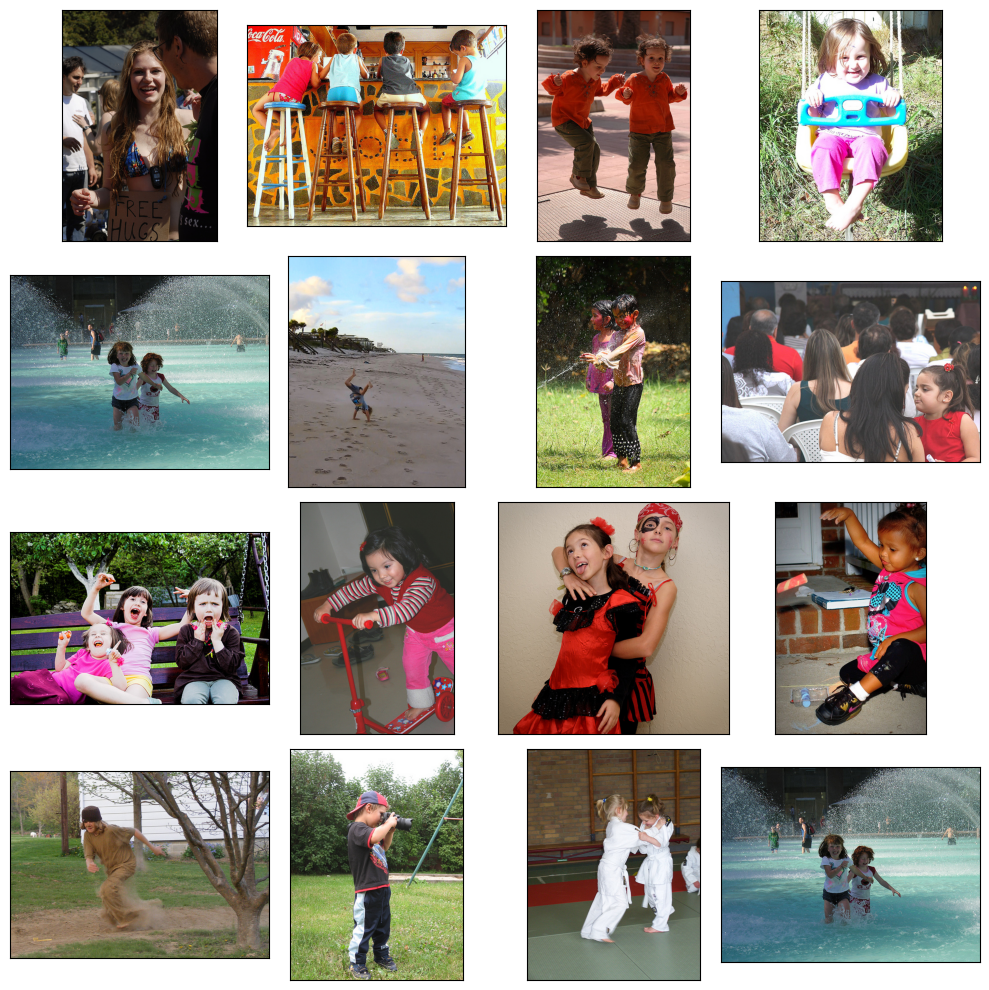

In [42]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(path_1, samples_block[i][:-2]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

plt.show()


Всё в порядке, на изображениях действиетльно присутствуют дети, можем удалить их из обучающей выборки.

In [43]:
train_data = train_data.loc[train_data['to_block'] == 0]

In [44]:
train_data.head(3)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   

                                          query_text  score  to_block  
0  A woman is signaling is to traffic , as seen f...    1.0         0  
3  A woman wearing black clothes , a purple scarf...    0.0         0  
4  An older woman with blond hair rides a bicycle...    0.0         0

**Вывод**
Мы проверили текстовые описания изображений ни изображения на присутствие на них детей и удалили их из обучающего набора данных. Перейдём к векторизации изображений.

# Векторизация изображений

Поскольку длина векторов изображений может быть сильно разной, так как размеры изображений разные, будем использовать свёрточные сети: они позволяют "выделить" главные компоненты изображений.

In [45]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=Path(path_1),
        x_col='image',
        y_col='score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=12345)
features, target = next(train_gen_flow)

Found 35825 validated image filenames.


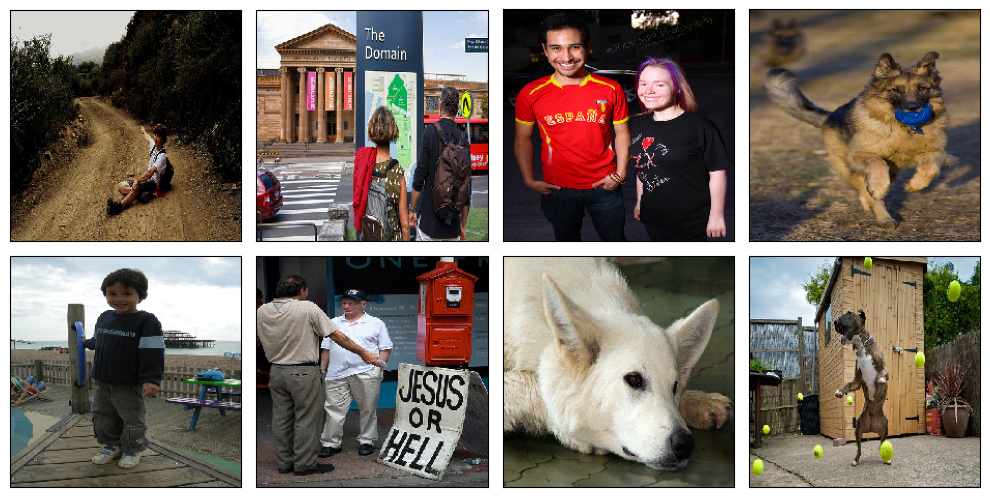

In [46]:
fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [47]:
def create_model():
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mae'])

    return model

In [48]:
def vectorize(model, train_data):
    predictions = model.predict(train_data)
    return predictions

In [49]:
model_image = create_model()

In [50]:
embeddings_image = vectorize(model_image, train_gen_flow)
embeddings_image.shape

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2240/2240 ━━━━━━━━━━━━━━━━━━━━ 6805s 3s/step


(35825, 2048)

In [56]:
print("Размер матрицы:", embeddings_image.shape)

Размер матрицы: (35825, 2048)


**Вывод**
Мы провели векторизацию изображений с помощью свёрточных сетей ResNet50().

# Векторизация текстов

Для векторизации текста будем использовать tf-idf.

Загрузим список стоп-слов на английском языке.

In [76]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
corpus = list(train_data['query_text'])

In [78]:
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

In [79]:
tf_idf = count_tf_idf.fit_transform(corpus)

In [81]:
print("Размер матрицы:", tf_idf.shape)

Размер матрицы: (35825, 1132)


**Вывод**
Мы выполнили векторизацию текста с помощью  tf-idf. Можем перейти к объединению векторов.

#  Объединение векторов

Объединим векторы изображений и векторы текстов с целевой переменной, подготавливая данные для обучения.

In [57]:
features = np.column_stack((embeddings_image, tf_idf.toarray()))
features.shape

(35825, 3180)

In [58]:
target = np.array(train_data['score'])
target.shape

(35825,)

Можно перейти к обучению модели.

In [93]:
train_data.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2   

                                          query_text  score  to_block  
0  A woman is signaling is to traffic , as seen f...    1.0         0  
3  A woman wearing black clothes , a purple scarf...    0.0         0  
4  An older woman with blond hair rides a bicycle...    0.0         0  
5  A woman wearing a white glove peers over the c...    0.0         0  
6      A man taking a picture with a silver camera .    0.0         0

# Обучение модели предсказания соответствия

Нам необходимо исключить попадание изображения и в обучающую, и в тестовую выборки. Для этого будем использовать класс GroupShuffleSplit из библиотеки sklearn.model_selection.
В качестве метрики предлагаем использовать RMSE, хоть эта метрика и чувствительна к аномальным значениям.

Разобьём датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

In [59]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=features, y=target, groups=train_data['image']))

In [60]:
X_train, X_test = features[train_indices], features[test_indices]

In [61]:
y_train, y_test = target[train_indices], target[test_indices]

In [62]:
X_train.shape

(24921, 3180)

In [63]:
X_test.shape

(10904, 3180)

In [64]:
y_train.shape

(24921,)

In [65]:
y_test.shape

(10904,)

In [66]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## LinearRegression

Обучим модель линейной регрессии.

In [67]:
model_lr = LinearRegression().fit(X_train, y_train)

predictions = model_lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE для модели линейной регрессии: {rmse_lr:.4f}')

RMSE для модели линейной регрессии: 0.5337


## Нейросеть

In [83]:
model_nn = Sequential()

model_nn.add(Dense(1024, input_shape=(3180,), activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(512, activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(1, activation='linear'))

model_nn.compile(loss='mean_squared_error',
                optimizer=Adam(learning_rate=0.0001),
                metrics=[RootMeanSquaredError()])

Обучим нейросеть.

In [ ]:
model_nn.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2
)

Epoch 1/10
779/779 - 50s - 64ms/step - loss: 0.5289 - root_mean_squared_error: 0.7272 - val_loss: 0.3290 - val_root_mean_squared_error: 0.5736
Epoch 2/10
779/779 - 49s - 62ms/step - loss: 0.3085 - root_mean_squared_error: 0.5554 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 3/10
779/779 - 46s - 59ms/step - loss: 0.2701 - root_mean_squared_error: 0.5197 - val_loss: 0.2979 - val_root_mean_squared_error: 0.5458
Epoch 4/10
779/779 - 48s - 61ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 5/10


In [85]:
pred_n = model_nn.predict(X_test)
nn_result = mean_squared_error(y_test, pred_n)
nn_result

341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


0.31874652451204744

In [86]:
result = {'model':['LinearRegression',
                        'Нейросеть'],
               'score':[rmse_lr,
                        nn_result
                       ]
              }
df_results = pd.DataFrame(result)
df_results

model     score
0  LinearRegression  0.533654
1         Нейросеть  0.318747

Нейросеть показала более хороший результат, чем линейная регрессия.

Данные были разделены на обучающую и тестовую выборки, для исключения попадания изображения и в обучающую, и в тестовую выборки мы использовали класс GroupShuffleSplit из библиотеки sklearn.model_selection. В качестве метрики вы выбрали RMSE, хоть эта метрика и чувствительна к аномальным значениям.
Провели обучение модели с помощью линейной регрессии и нейросети. Более хороший результат показала нейросеть, значение RMSE составило - 0.3187, тогда как RMSE модели линейной регрессии достигло 0.5337.

# Тестирование модели

Для тестирования нам необходимо создать функцию, которая принимает на вход текстовое описание, делает векторизацию и возвращает картинку с максимальным значением метрики. Если запрос связан с запретными словами, функция должна вывести предупреждение.

In [206]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=test_queries,
        directory=Path(path_2),
        x_col='image',
        y_col='score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=42)

Found 500 validated image filenames.


In [207]:
embeddings_image_test = vectorize(model_image, test_gen_flow)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step


In [98]:
embeddings_image_test.shape

(500, 2048)

In [99]:
corpus_2 = list(test_queries['query_text'])

In [100]:
count_tf_idf_2 = TfidfVectorizer(stop_words=list(stopwords))

In [101]:
tf_idf_2 = count_tf_idf_2.fit_transform(corpus_2)

In [102]:
tf_idf_2.shape

(500, 807)

In [295]:
 def final(text):
     data = pd.concat((test_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='predictions')), axis=1)
     top = list(data.sort_values(by='predictions', ascending=False)['image'].head(5))
     top_score = list(data.sort_values(by='predictions', ascending=False)['predictions'].head(5))


     fig = plt.figure(figsize=(15,5))
     plt.rcParams['axes.edgecolor'] = 'black'
     plt.rcParams['axes.linewidth'] = 0
     for i in range(5):
      fig.add_subplot(1, 6, i + 1, title=round(top_score[i], 2))
      image = Image.open(Path(path_2, top[i]))
      plt.imshow(image)
      plt.xticks([])
      plt.yticks([])
      plt.tight_layout()

      if text in list(test_queries['query_text']):
        plt.rcParams['axes.edgecolor'] = 'green'
        plt.rcParams['axes.linewidth'] = 5
        fig.add_subplot(1, 6, 6)
        image = Image.open(Path(path_2, test_queries.iloc[test_queries[test_queries['query_text'] == text].index[0]]['image']))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        print()

plt.show()

TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'float'

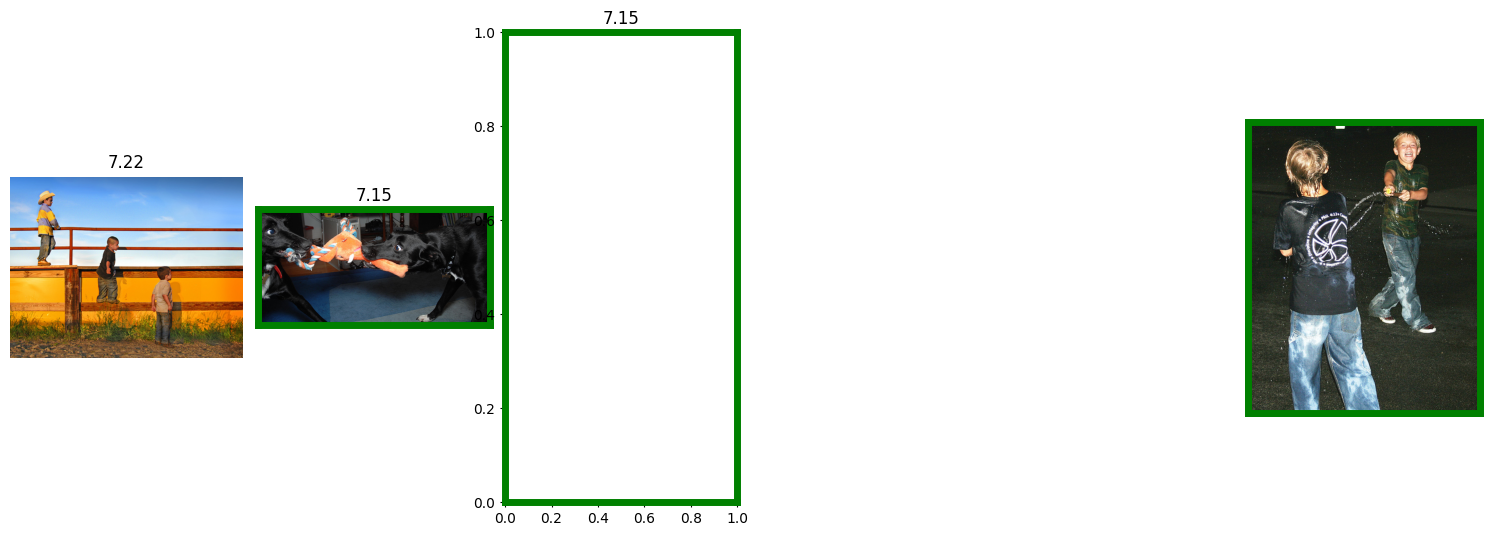

In [297]:
finals = list(test_queries['query_text'].astype(str).sample(10))
for text in finals:
    final(text)


# Вывод

Нами была протестирована модель, которая сравнивала описание изображения и само изображение. Мы учли, чтобы из запросов были исключены запрещённые слова. Для тестирвоания нами была выбрана модель, которая показала лучший результат при обучении, но по результатам тестирования можно заключить, что модель нужнается в усовершенствовании. Для улучшения результатов, возможно, стоит рассмотреть другие методы векторизации текста и изображений.